In [3]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import math

Import data and standarize.

In [4]:
student_resume_input = pd.read_csv("data_X.csv",index_col="Serial_id")
admit_chance_target = pd.read_csv("data_T.csv",index_col="Serial_id")
# normalize y = (x - min) / (max - min) or standardize	y = (x - mean) / standard_deviation
# student_resume_input = (student_resume_input-student_resume_input.mean())/student_resume_input.std()

# arangement input
train_x = student_resume_input.iloc[:int(len(student_resume_input) * 0.8)].values
train_y = admit_chance_target.iloc[:int(len(admit_chance_target) * 0.8)].values
test_x = student_resume_input.iloc[int(len(student_resume_input) * 0.8):].values
test_y = admit_chance_target.iloc[int(len(admit_chance_target) * 0.8):].values

In [5]:
class PolynomialRegression:
  def __init__(self, feature_num):
    self.feature_num = feature_num

  def fit(self, x, y):
    # Maximum likelihood and least squares
    # w = (Phi^T・Phi)^(-1)・Phi^T・t
    xTx = np.dot(x.T,x)
    w = np.dot(np.dot(np.linalg.pinv(xTx),x.T),y)
    return w

  def RLS(self, x, y, lmbd):
    # Regularized Least Squares
    # w = (lambda・I + Phi^T・Phi)^-1 ・ Phi^T ・ t
    xTx = np.dot(x.T,x)
    I = np.eye(len(xTx))
    rglr = np.dot(lmbd, I) + xTx
    w = np.dot(np.dot(np.linalg.pinv(rglr),x.T),y)
    return w

  def RMSE(self, x, w, t):
    E = (np.dot(x,w) - t) ** 2
    Erms = math.sqrt(np.mean(E))
    return Erms

  def PhiMatrix(self, x, M):
    pcol = np.ones((len(x),1))
    for i in range(1,M+1):
      for combination in list(itertools.combinations_with_replacement(range(self.feature_num), i)):
        # combinations_with_replacement('ABCD', 2) => AA AB AC AD BB BC BD CC CD DD
        # concatenate: axis=1 => AAABACADBBBCBDCCCDDD
        new_pcol = np.expand_dims(np.prod(x[:, combination], axis = 1), axis = 1)
        pcol = np.concatenate((pcol,new_pcol),axis=1)
    return pcol

**2-1-a**  Feature Select - Evaluate RMS error

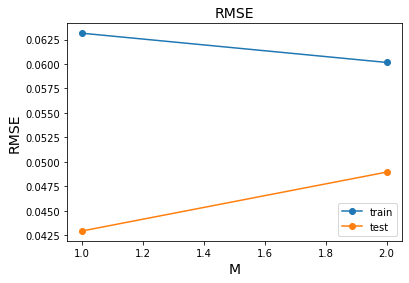

M=1, training RMSE: 0.063142, testing RMSE: 0.042932
M=2, training RMSE: 0.060157, testing RMSE: 0.048945


In [6]:
M_max = 2
train_RMSE = []
test_RMSE = []

PR = PolynomialRegression(feature_num=7)

for m in range(1, M_max+1):
  train_xnew = PR.PhiMatrix(train_x,m)
  test_xnew = PR.PhiMatrix(test_x,m)
  w = PR.fit(train_xnew,train_y)
  RMSError_train = PR.RMSE(train_xnew, w, train_y)
  RMSError_test = PR.RMSE(test_xnew, w, test_y)

  train_RMSE.append(RMSError_train)
  test_RMSE.append(RMSError_test)
# print(w)

plt.plot([i for i in range(1,M_max+1)],train_RMSE,marker='o',label='train')
plt.plot([i for i in range(1,M_max+1)],test_RMSE,marker='o',label='test')

plt.xlabel('M',fontsize=14)
plt.ylabel('RMSE',fontsize=14)
plt.legend()
plt.title("RMSE",fontsize=14)
plt.show()

for i in range(1, M_max+1):
  print("M=%d, training RMSE: %f, testing RMSE: %f" % (i, train_RMSE[i-1], test_RMSE[i-1]))


**2-1-b**  Feature Select - Analyze weight and select the most contributive feature

In [7]:
M_max = 1
train_RMSE = []
test_RMSE = []

PR = PolynomialRegression(feature_num=7)

for m in range(1, M_max+1):
  train_xnew = PR.PhiMatrix(train_x,m)
  test_xnew = PR.PhiMatrix(test_x,m)
  w = PR.fit(train_xnew,train_y)
  RMSError_train = PR.RMSE(train_xnew, w, train_y)
  RMSError_test = PR.RMSE(test_xnew, w, test_y)
  
  train_RMSE.append(RMSError_train)
  test_RMSE.append(RMSError_test)
print("Weights for M=1:\n",w)
print()

Dimen = {0,1,2,3,4,5,6}
for feature_attri in list(itertools.combinations(range(0,7),6)):
  FAPR = PolynomialRegression(feature_num=len(feature_attri))
  fa_train_x = FAPR.PhiMatrix(train_x[:,list(feature_attri)],1)
  w = FAPR.fit(fa_train_x,train_y)
  RMSError_fa = FAPR.RMSE(fa_train_x,w,train_y)
  setF = set(list(feature_attri))

  print("Dimension M:%d, Judge_index: " % (1), Dimen^setF, "\nRMSE: ", RMSError_fa)
  print()

Weights for M=1:
 [[-1.25943248]
 [ 0.00173741]
 [ 0.00291958]
 [ 0.00571666]
 [-0.00330517]
 [ 0.02235313]
 [ 0.11893945]
 [ 0.02452511]]

Dimension M:1, Judge_index:  {6} 
RMSE:  0.06390185725541248

Dimension M:1, Judge_index:  {5} 
RMSE:  0.07035976310693098

Dimension M:1, Judge_index:  {4} 
RMSE:  0.06443899165693007

Dimension M:1, Judge_index:  {3} 
RMSE:  0.06317028722316699

Dimension M:1, Judge_index:  {2} 
RMSE:  0.0632574013178459

Dimension M:1, Judge_index:  {1} 
RMSE:  0.06371753663473695

Dimension M:1, Judge_index:  {0} 
RMSE:  0.06381829679381827



首先印出 M=1 時，各 weight 的值(第一項對應 bias W0)，
可以看到 w5(對應第六項feature)的值最大。
接著輪流剔除一項feature，放入 model 計算RMSE，可以看到剔除 feature[5] 的 RMSE 最大。由以上結果可推知第六項 feature - CGPA 的貢獻最大。

**2-2-b**  Introduce the basis function you just decided in (a) to linear regression model and analyze the result you get.

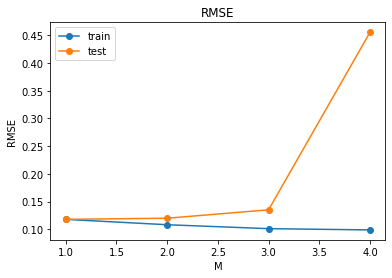

M=1, training RMSE: 0.117800, testing RMSE: 0.117878
M=2, training RMSE: 0.108118, testing RMSE: 0.119880
M=3, training RMSE: 0.101038, testing RMSE: 0.135055
M=4, training RMSE: 0.098770, testing RMSE: 0.455512


In [8]:
def Gaussian(x, mean, sigma):
  return np.exp(-1 * (x-mean)**2 / (2* (sigma**2)))

def Sigmoid(x, mean, sigma):
  return 1 / ( 1 + np.exp( -(x-mean) / sigma))

trainx_Phi = np.ones(train_x.shape)
testx_Phi = np.ones(test_x.shape)

method = Gaussian
# method = Sigmoid
sigma = 0.1
M_max = 4

# put basis function into Phi matrix
if method == Gaussian:
  for i in range(train_x.shape[1]):
    trainx_Phi[:,i] = Gaussian(train_x[:,i], train_x[:,i].mean(), sigma)
  for i in range(test_x.shape[1]):
    testx_Phi[:,i] = Gaussian(test_x[:,i], train_x[:,i].mean(), sigma)
elif method == Sigmoid:
  for i in range(train_x.shape[1]):
    trainx_Phi[:,i] = Sigmoid(train_x[:,i], train_x[:,i].mean(), sigma)
  for i in range(test_x.shape[1]):
    testx_Phi[:,i] = Sigmoid(test_x[:,i], train_x[:,i].mean(), sigma)

train_RMSE = []
test_RMSE = []

PR = PolynomialRegression(feature_num=7)

# f(g(x))
for m in range(1, M_max+1):
  train_xnew = PR.PhiMatrix(trainx_Phi,m)
  test_xnew = PR.PhiMatrix(testx_Phi,m)
  w = PR.fit(train_xnew,train_y)
  RMSError_train = PR.RMSE(train_xnew, w, train_y)
  RMSError_test = PR.RMSE(test_xnew, w, test_y)

  train_RMSE.append(RMSError_train)
  test_RMSE.append(RMSError_test)
# print(w)

plt.plot([i for i in range(1,M_max+1)],train_RMSE,marker='o',label='train')
plt.plot([i for i in range(1,M_max+1)],test_RMSE,marker='o',label='test')

plt.xlabel('M')
plt.ylabel('RMSE')
plt.legend()
plt.title("RMSE")
plt.show()

for i in range(1, M_max+1):
  print("M=%d, training RMSE: %f, testing RMSE: %f" % (i, train_RMSE[i-1], test_RMSE[i-1]))


**2-2-c**  Apply N-fold cross-validation in your training stage to select at least one hyper-parameter for model.

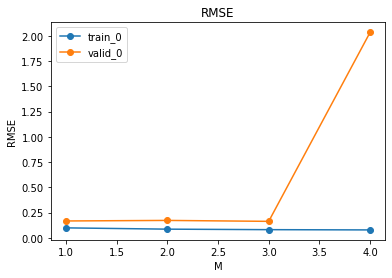

M=1, training RMSE: 0.098338, validation RMSE: 0.166663
M=2, training RMSE: 0.085581, validation RMSE: 0.172014
M=3, training RMSE: 0.080584, validation RMSE: 0.162829
M=4, training RMSE: 0.078030, validation RMSE: 2.034917


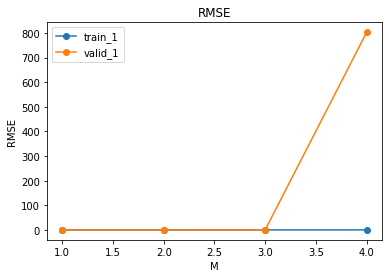

M=1, training RMSE: 0.122146, validation RMSE: 0.107293
M=2, training RMSE: 0.110931, validation RMSE: 0.109193
M=3, training RMSE: 0.105295, validation RMSE: 0.404435
M=4, training RMSE: 0.102881, validation RMSE: 802.751612


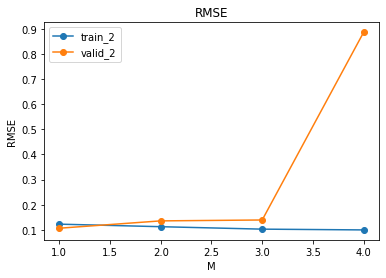

M=1, training RMSE: 0.122544, validation RMSE: 0.106402
M=2, training RMSE: 0.112432, validation RMSE: 0.135585
M=3, training RMSE: 0.102694, validation RMSE: 0.139145
M=4, training RMSE: 0.099619, validation RMSE: 0.886167


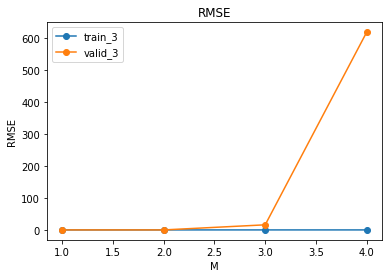

M=1, training RMSE: 0.123066, validation RMSE: 0.104566
M=2, training RMSE: 0.113704, validation RMSE: 0.105898
M=3, training RMSE: 0.108538, validation RMSE: 16.033955
M=4, training RMSE: 0.105984, validation RMSE: 618.134650

For M = 1, average of validation error = 0.121231
For M = 2, average of validation error = 0.130673
For M = 3, average of validation error = 4.185091
For M = 4, average of validation error = 355.951837


In [9]:
# N-fold (K-fold) cross-validation
K = 4
M_max = 4

X = student_resume_input.iloc[:int(len(student_resume_input) * 0.8)]
Y = admit_chance_target.iloc[:int(len(admit_chance_target) * 0.8)]

train_x_0 = train_x[int(len(train_x) * 0.25):]
train_y_0 = train_y[int(len(train_y) * 0.25):]
valid_x_0 = train_x[:int(len(train_x) * 0.25)]
valid_y_0 = train_y[:int(len(train_y) * 0.25)]

train_x_1 = np.vstack((X[:int(len(X) * 0.25)], X[int(len(X) * 0.5):]))
train_y_1 = np.vstack((Y[:int(len(Y) * 0.25)], Y[int(len(Y) * 0.5):]))
valid_x_1 = train_x[int(len(train_x) * 0.25):int(len(train_x) * 0.5)]
valid_y_1 = train_y[int(len(train_x) * 0.25):int(len(train_x) * 0.5)]

train_x_2 = np.vstack((X[:int(len(X) * 0.5)], X[int(len(X) * 0.75):]))
train_y_2 = np.vstack((Y[:int(len(Y) * 0.5)], Y[int(len(Y) * 0.75):]))
valid_x_2 = train_x[int(len(train_x) * 0.5):int(len(train_x) * 0.75)]
valid_y_2 = train_y[int(len(train_x) * 0.5):int(len(train_x) * 0.75)]

train_x_3 = train_x[:int(len(train_x) * 0.75)]
train_y_3 = train_y[:int(len(train_y) * 0.75)]
valid_x_3 = train_x[int(len(train_x) * 0.75):]
valid_y_3 = train_y[int(len(train_y) * 0.75):]

method = Gaussian
# method = Sigmoid
sigma = 0.099
M_max = 4

for i in range(K):
  if i == 0:
    Trainx_Phi = np.ones(train_x_0.shape)
    Validx_Phi = np.ones(valid_x_0.shape)
    train_RMSE0 = []
    valid_RMSE0 = []
    for i in range(train_x_0.shape[1]):
      Trainx_Phi[:,i] = Gaussian(train_x_0[:,i], train_x_0[:,i].mean(), sigma)
    for i in range(valid_x_0.shape[1]):
      Validx_Phi[:,i] = Gaussian(valid_x_0[:,i], train_x_0[:,i].mean(), sigma)
    
    for m in range(1, M_max+1):
      Train_xnew = PR.PhiMatrix(Trainx_Phi,m)
      Valid_xnew = PR.PhiMatrix(Validx_Phi,m)
      w = PR.fit(Train_xnew,train_y_0)
      RMSError_train = PR.RMSE(Train_xnew, w, train_y_0)
      RMSError_valid = PR.RMSE(Valid_xnew, w, valid_y_0)

      train_RMSE0.append(RMSError_train)
      valid_RMSE0.append(RMSError_valid)
    # print(w)

    plt.plot([i for i in range(1,M_max+1)],train_RMSE0,marker='o',label='train_0')
    plt.plot([i for i in range(1,M_max+1)],valid_RMSE0,marker='o',label='valid_0')

    plt.xlabel('M')
    plt.ylabel('RMSE')
    # plt.ylim(0,1)
    plt.legend()
    plt.title("RMSE")
    plt.show()

    for i in range(1, M_max+1):
      print("M=%d, training RMSE: %f, validation RMSE: %f" % (i, train_RMSE0[i-1], valid_RMSE0[i-1]))

  elif i == 1:
    Trainx_Phi = np.ones(train_x_1.shape)
    Validx_Phi = np.ones(valid_x_1.shape)
    train_RMSE1 = []
    valid_RMSE1 = []

    for i in range(train_x_0.shape[1]):
      Trainx_Phi[:,i] = Gaussian(train_x_1[:,i], train_x_1[:,i].mean(), sigma)
    for i in range(valid_x_0.shape[1]):
      Validx_Phi[:,i] = Gaussian(valid_x_1[:,i], train_x_1[:,i].mean(), sigma)

    for m in range(1, M_max+1):
      Train_xnew = PR.PhiMatrix(Trainx_Phi,m)
      Valid_xnew = PR.PhiMatrix(Validx_Phi,m)
      w = PR.fit(Train_xnew,train_y_1)
      RMSError_train = PR.RMSE(Train_xnew, w, train_y_1)
      RMSError_valid = PR.RMSE(Valid_xnew, w, valid_y_1)

      train_RMSE1.append(RMSError_train)
      valid_RMSE1.append(RMSError_valid)
    # print(w)

    plt.plot([i for i in range(1,M_max+1)],train_RMSE1,marker='o',label='train_1')
    plt.plot([i for i in range(1,M_max+1)],valid_RMSE1,marker='o',label='valid_1')

    plt.xlabel('M')
    plt.ylabel('RMSE')
    # plt.ylim(0,1)
    plt.legend()
    plt.title("RMSE")
    plt.show()

    for i in range(1, M_max+1):
      print("M=%d, training RMSE: %f, validation RMSE: %f" % (i, train_RMSE1[i-1], valid_RMSE1[i-1]))

  elif i == 2:
    Trainx_Phi = np.ones(train_x_2.shape)
    Validx_Phi = np.ones(valid_x_2.shape)
    train_RMSE2 = []
    valid_RMSE2 = []

    for i in range(train_x_0.shape[1]):
      Trainx_Phi[:,i] = Gaussian(train_x_2[:,i], train_x_2[:,i].mean(), sigma)
    for i in range(valid_x_0.shape[1]):
      Validx_Phi[:,i] = Gaussian(valid_x_2[:,i], train_x_2[:,i].mean(), sigma)

    for m in range(1, M_max+1):
      Train_xnew = PR.PhiMatrix(Trainx_Phi,m)
      Valid_xnew = PR.PhiMatrix(Validx_Phi,m)
      w = PR.fit(Train_xnew,train_y_2)
      RMSError_train = PR.RMSE(Train_xnew, w, train_y_2)
      RMSError_valid = PR.RMSE(Valid_xnew, w, valid_y_2)

      train_RMSE2.append(RMSError_train)
      valid_RMSE2.append(RMSError_valid)
    # print(w)

    plt.plot([i for i in range(1,M_max+1)],train_RMSE2,marker='o',label='train_2')
    plt.plot([i for i in range(1,M_max+1)],valid_RMSE2,marker='o',label='valid_2')

    plt.xlabel('M')
    plt.ylabel('RMSE')
    # plt.ylim(0,1)
    plt.legend()
    plt.title("RMSE")
    plt.show()

    for i in range(1, M_max+1):
      print("M=%d, training RMSE: %f, validation RMSE: %f" % (i, train_RMSE2[i-1], valid_RMSE2[i-1]))

  elif i == 3:
    trainx_Phi = np.ones(train_x_3.shape)
    validx_Phi = np.ones(valid_x_3.shape)
    train_RMSE3 = []
    valid_RMSE3 = []

    for i in range(train_x_0.shape[1]):
      Trainx_Phi[:,i] = Gaussian(train_x_3[:,i], train_x_3[:,i].mean(), sigma)
    for i in range(valid_x_0.shape[1]):
      Validx_Phi[:,i] = Gaussian(valid_x_3[:,i], train_x_3[:,i].mean(), sigma)

    for m in range(1, M_max+1):
      Train_xnew = PR.PhiMatrix(Trainx_Phi,m)
      Valid_xnew = PR.PhiMatrix(Validx_Phi,m)
      w = PR.fit(Train_xnew,train_y_3)
      RMSError_train = PR.RMSE(Train_xnew, w, train_y_3)
      RMSError_valid = PR.RMSE(Valid_xnew, w, valid_y_3)

      train_RMSE3.append(RMSError_train)
      valid_RMSE3.append(RMSError_valid)
    # print(w)

    plt.plot([i for i in range(1,M_max+1)],train_RMSE3,marker='o',label='train_3')
    plt.plot([i for i in range(1,M_max+1)],valid_RMSE3,marker='o',label='valid_3')

    plt.xlabel('M')
    plt.ylabel('RMSE')
    # plt.ylim(0,1)
    plt.legend()
    plt.title("RMSE")
    plt.show()

    for i in range(1, M_max+1):
      print("M=%d, training RMSE: %f, validation RMSE: %f" % (i, train_RMSE3[i-1], valid_RMSE3[i-1]))

print()
Valid_mean = []
for i in range(M_max):
  Valid_mean.append((valid_RMSE0[i] + valid_RMSE1[i] + valid_RMSE2[i] + valid_RMSE3[i]) / M_max)
  print("For M = %d, average of validation error = %f" % (i+1, Valid_mean[i]))

**2-3-b**  Use Maximum a posterior approach method to retest the model in 2-2 you designed. You could choose Gaussian distribution as a prior.

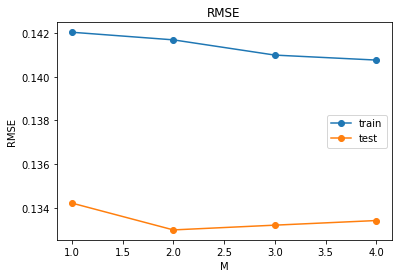

M=1, training RMSE: 0.142037, testing RMSE: 0.134219
M=2, training RMSE: 0.141688, testing RMSE: 0.132992
M=3, training RMSE: 0.140991, testing RMSE: 0.133210
M=4, training RMSE: 0.140763, testing RMSE: 0.133422


In [10]:
trainx_Phi = np.ones(train_x.shape)
testx_Phi = np.ones(test_x.shape)

# method = Gaussian
sigma = 0.1
M_max = 4
lmbd = 0.1

# put basis function into Phi matrix
for i in range(train_x.shape[1]):
  trainx_Phi[:,i] = Gaussian(train_x[:,i], train_x[:,i].mean(), sigma)
for i in range(test_x.shape[1]):
  testx_Phi[:,i] = Gaussian(test_x[:,i], train_x[:,i].mean(), sigma)

train_RMSE = []
test_RMSE = []

PR = PolynomialRegression(feature_num=7)

# f(g(x))
for m in range(1, M_max+1):
  train_xnew = PR.PhiMatrix(trainx_Phi,m)
  test_xnew = PR.PhiMatrix(testx_Phi,m)
  w = PR.RLS(train_xnew,train_y,lmbd)
  RMSError_train = PR.RMSE(train_xnew, w, train_y)
  RMSError_test = PR.RMSE(test_xnew, w, test_y)

  train_RMSE.append(RMSError_train)
  test_RMSE.append(RMSError_test)
# print(w)

plt.plot([i for i in range(1,M_max+1)],train_RMSE,marker='o',label='train')
plt.plot([i for i in range(1,M_max+1)],test_RMSE,marker='o',label='test')

plt.xlabel('M')
plt.ylabel('RMSE')
plt.legend()
plt.title("RMSE")
plt.show()

for i in range(1, M_max+1):
  print("M=%d, training RMSE: %f, testing RMSE: %f" % (i, train_RMSE[i-1], test_RMSE[i-1]))


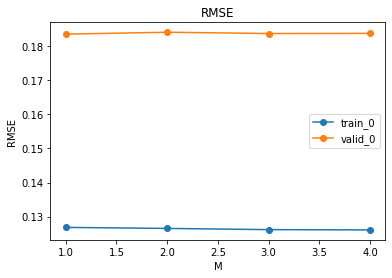

M=1, training RMSE: 0.126847, validation RMSE: 0.183500
M=2, training RMSE: 0.126542, validation RMSE: 0.184048
M=3, training RMSE: 0.126194, validation RMSE: 0.183674
M=4, training RMSE: 0.126107, validation RMSE: 0.183720


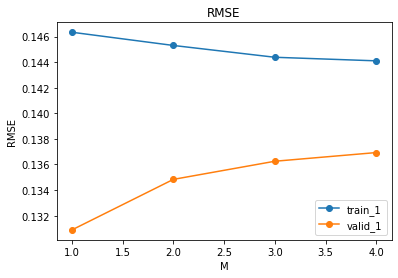

M=1, training RMSE: 0.146333, validation RMSE: 0.130888
M=2, training RMSE: 0.145300, validation RMSE: 0.134836
M=3, training RMSE: 0.144378, validation RMSE: 0.136253
M=4, training RMSE: 0.144098, validation RMSE: 0.136931


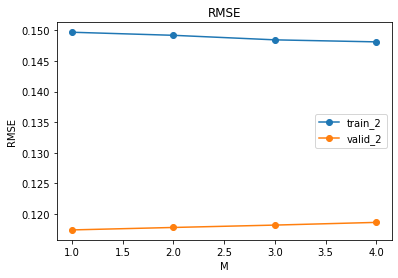

M=1, training RMSE: 0.149710, validation RMSE: 0.117372
M=2, training RMSE: 0.149208, validation RMSE: 0.117774
M=3, training RMSE: 0.148465, validation RMSE: 0.118162
M=4, training RMSE: 0.148134, validation RMSE: 0.118604


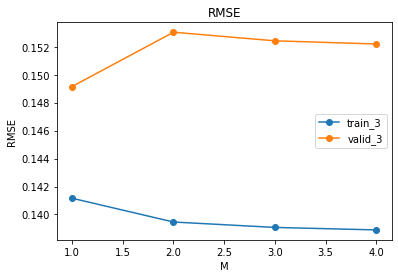

M=1, training RMSE: 0.141163, validation RMSE: 0.149155
M=2, training RMSE: 0.139462, validation RMSE: 0.153036
M=3, training RMSE: 0.139075, validation RMSE: 0.152423
M=4, training RMSE: 0.138897, validation RMSE: 0.152195

For M = 1, average of validation error = 0.145229
For M = 2, average of validation error = 0.147424
For M = 3, average of validation error = 0.147628
For M = 4, average of validation error = 0.147863


In [12]:
method = Gaussian
sigma = 0.1
M_max = 4
lmbd = 0.1

for i in range(K):
  if i == 0:
    Trainx_Phi = np.ones(train_x_0.shape)
    Validx_Phi = np.ones(valid_x_0.shape)
    train_RMSE0 = []
    valid_RMSE0 = []
    for i in range(train_x_0.shape[1]):
      Trainx_Phi[:,i] = Gaussian(train_x_0[:,i], train_x_0[:,i].mean(), sigma)
    for i in range(valid_x_0.shape[1]):
      Validx_Phi[:,i] = Gaussian(valid_x_0[:,i], train_x_0[:,i].mean(), sigma)
    
    for m in range(1, M_max+1):
      Train_xnew = PR.PhiMatrix(Trainx_Phi,m)
      Valid_xnew = PR.PhiMatrix(Validx_Phi,m)
      w = PR.RLS(Train_xnew,train_y_0,lmbd)
      RMSError_train = PR.RMSE(Train_xnew, w, train_y_0)
      RMSError_valid = PR.RMSE(Valid_xnew, w, valid_y_0)

      train_RMSE0.append(RMSError_train)
      valid_RMSE0.append(RMSError_valid)
    # print(w)

    plt.plot([i for i in range(1,M_max+1)],train_RMSE0,marker='o',label='train_0')
    plt.plot([i for i in range(1,M_max+1)],valid_RMSE0,marker='o',label='valid_0')

    plt.xlabel('M')
    plt.ylabel('RMSE')
    # plt.ylim(0,1)
    plt.legend()
    plt.title("RMSE")
    plt.show()

    for i in range(1, M_max+1):
      print("M=%d, training RMSE: %f, validation RMSE: %f" % (i, train_RMSE0[i-1], valid_RMSE0[i-1]))

  elif i == 1:
    Trainx_Phi = np.ones(train_x_1.shape)
    Validx_Phi = np.ones(valid_x_1.shape)
    train_RMSE1 = []
    valid_RMSE1 = []

    for i in range(train_x_0.shape[1]):
      Trainx_Phi[:,i] = Gaussian(train_x_1[:,i], train_x_1[:,i].mean(), sigma)
    for i in range(valid_x_0.shape[1]):
      Validx_Phi[:,i] = Gaussian(valid_x_1[:,i], train_x_1[:,i].mean(), sigma)

    for m in range(1, M_max+1):
      Train_xnew = PR.PhiMatrix(Trainx_Phi,m)
      Valid_xnew = PR.PhiMatrix(Validx_Phi,m)
      w = PR.RLS(Train_xnew,train_y_1,lmbd)
      RMSError_train = PR.RMSE(Train_xnew, w, train_y_1)
      RMSError_valid = PR.RMSE(Valid_xnew, w, valid_y_1)

      train_RMSE1.append(RMSError_train)
      valid_RMSE1.append(RMSError_valid)
    # print(w)

    plt.plot([i for i in range(1,M_max+1)],train_RMSE1,marker='o',label='train_1')
    plt.plot([i for i in range(1,M_max+1)],valid_RMSE1,marker='o',label='valid_1')

    plt.xlabel('M')
    plt.ylabel('RMSE')
    # plt.ylim(0,1)
    plt.legend()
    plt.title("RMSE")
    plt.show()

    for i in range(1, M_max+1):
      print("M=%d, training RMSE: %f, validation RMSE: %f" % (i, train_RMSE1[i-1], valid_RMSE1[i-1]))

  elif i == 2:
    Trainx_Phi = np.ones(train_x_2.shape)
    Validx_Phi = np.ones(valid_x_2.shape)
    train_RMSE2 = []
    valid_RMSE2 = []

    for i in range(train_x_0.shape[1]):
      Trainx_Phi[:,i] = Gaussian(train_x_2[:,i], train_x_2[:,i].mean(), sigma)
    for i in range(valid_x_0.shape[1]):
      Validx_Phi[:,i] = Gaussian(valid_x_2[:,i], train_x_2[:,i].mean(), sigma)

    for m in range(1, M_max+1):
      Train_xnew = PR.PhiMatrix(Trainx_Phi,m)
      Valid_xnew = PR.PhiMatrix(Validx_Phi,m)
      w = PR.RLS(Train_xnew,train_y_2,lmbd)
      RMSError_train = PR.RMSE(Train_xnew, w, train_y_2)
      RMSError_valid = PR.RMSE(Valid_xnew, w, valid_y_2)

      train_RMSE2.append(RMSError_train)
      valid_RMSE2.append(RMSError_valid)
    # print(w)

    plt.plot([i for i in range(1,M_max+1)],train_RMSE2,marker='o',label='train_2')
    plt.plot([i for i in range(1,M_max+1)],valid_RMSE2,marker='o',label='valid_2')

    plt.xlabel('M')
    plt.ylabel('RMSE')
    # plt.ylim(0,1)
    plt.legend()
    plt.title("RMSE")
    plt.show()

    for i in range(1, M_max+1):
      print("M=%d, training RMSE: %f, validation RMSE: %f" % (i, train_RMSE2[i-1], valid_RMSE2[i-1]))

  elif i == 3:
    trainx_Phi = np.ones(train_x_3.shape)
    validx_Phi = np.ones(valid_x_3.shape)
    train_RMSE3 = []
    valid_RMSE3 = []

    for i in range(train_x_0.shape[1]):
      Trainx_Phi[:,i] = Gaussian(train_x_3[:,i], train_x_3[:,i].mean(), sigma)
    for i in range(valid_x_0.shape[1]):
      Validx_Phi[:,i] = Gaussian(valid_x_3[:,i], train_x_3[:,i].mean(), sigma)

    for m in range(1, M_max+1):
      Train_xnew = PR.PhiMatrix(Trainx_Phi,m)
      Valid_xnew = PR.PhiMatrix(Validx_Phi,m)
      w = PR.RLS(Train_xnew,train_y_3,lmbd)
      RMSError_train = PR.RMSE(Train_xnew, w, train_y_3)
      RMSError_valid = PR.RMSE(Valid_xnew, w, valid_y_3)

      train_RMSE3.append(RMSError_train)
      valid_RMSE3.append(RMSError_valid)
    # print(w)

    plt.plot([i for i in range(1,M_max+1)],train_RMSE3,marker='o',label='train_3')
    plt.plot([i for i in range(1,M_max+1)],valid_RMSE3,marker='o',label='valid_3')

    plt.xlabel('M')
    plt.ylabel('RMSE')
    # plt.ylim(0,1)
    plt.legend()
    plt.title("RMSE")
    plt.show()

    for i in range(1, M_max+1):
      print("M=%d, training RMSE: %f, validation RMSE: %f" % (i, train_RMSE3[i-1], valid_RMSE3[i-1]))

print()
Valid_mean = []
for i in range(M_max):
  Valid_mean.append((valid_RMSE0[i] + valid_RMSE1[i] + valid_RMSE2[i] + valid_RMSE3[i]) / M_max)
  print("For M = %d, average of validation error = %f" % (i+1, Valid_mean[i]))